In [1]:
import pandas as pd
from konlpy.tag import Okt

In [54]:
import numpy as np

In [63]:
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
okt = Okt()

In [6]:
positive_dict = pd.read_csv('positive_score_dict.csv')
positive_dict = positive_dict.drop_duplicates(subset='단어')
positive_dict.set_index('단어', inplace=True)

result2 = pd.read_csv('community_add_market.csv', low_memory=False)

In [7]:
result2.head(1)

,닉네임,날짜,내용,종목,내용_토큰,label,시장,명사_추출
0,GROK,2025-01-11T22:59:18+09:00,- 디자인 변화: S25 울트라는 기존의 각진 디자인에서 둥근 모서리로 변경되었으며...,005930,디자인 변화 울트라 기존 디자인 에서 둥글다 모서리 변경 되어다 카메라 모듈 디자인...,1,KOSPI,디자인 변화 울트라 기존 디자인 모서리 변경 카메라 모듈 디자인 변화 플러스 외관 ...


In [8]:
result2['label'].value_counts()

label
 0    44198
-1    15335
 1    12979
Name: count, dtype: int64

In [9]:
# 학습을 위해 1, 0으로 긍정/ 부정을 재구분
result2['긍정점수'] = [1 if label == 1 else 0 if label == -1 else -1 for label in result2['label']]

In [10]:
result2.head(1)

,닉네임,날짜,내용,종목,내용_토큰,label,시장,명사_추출,긍정점수
0,GROK,2025-01-11T22:59:18+09:00,- 디자인 변화: S25 울트라는 기존의 각진 디자인에서 둥근 모서리로 변경되었으며...,005930,디자인 변화 울트라 기존 디자인 에서 둥글다 모서리 변경 되어다 카메라 모듈 디자인...,1,KOSPI,디자인 변화 울트라 기존 디자인 모서리 변경 카메라 모듈 디자인 변화 플러스 외관 ...,1


In [11]:
result2['긍정점수'].value_counts()

긍정점수
-1    44198
 0    15335
 1    12979
Name: count, dtype: int64

In [12]:
# '내용_토큰'이 NaN인 행 제거
result3 = result2.dropna(subset=['내용_토큰'])

In [13]:
result3['긍정점수'].value_counts()

긍정점수
-1    44198
 0    15335
 1    12979
Name: count, dtype: int64

In [31]:
result3 = result3.drop_duplicates(subset=['내용_토큰'])

In [32]:
result3['긍정점수'].value_counts()

긍정점수
-1    36103
 0    14301
 1    12295
Name: count, dtype: int64

In [106]:
# 언더 샘플링

sample_data_positive = result3[result3['긍정점수'] == 1].sample(12295)
sample_data_negative = result3[result3['긍정점수'] == 0].sample(12295)

total_data = pd.concat([sample_data_positive,sample_data_negative])

In [107]:
total_data['내용_토큰'].nunique()

24590

In [108]:
print(total_data.isnull().values.any())

True


In [109]:
print(total_data.isnull().sum())

닉네임         0
날짜          0
내용          0
종목          0
내용_토큰       0
label       0
시장          0
명사_추출    1106
긍정점수        0
dtype: int64


<Axes: xlabel='긍정점수'>

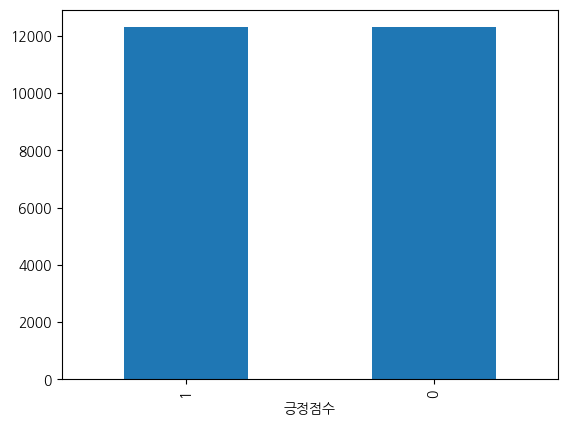

In [110]:
total_data['긍정점수'].value_counts().plot(kind = 'bar')

In [111]:
# 학습 데이터와, 테스트 데이터를 구분

train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=2025)

In [112]:
X_train = train_data['내용_토큰'].tolist()

In [113]:
X_train[:3]

['넘다 신성 보유 자다 그렇다 지키다 보다 뛰다 따라가다 자의 슬픔 아니다 미래엔 기쁨 아무 진정하다 신성 모르다 신성하다 주식 신성 이여',
 '기업 이름 가리다 일주일 차트 누르다 보다 당장 쏘다 이상하다 않다',
 '그냥 이자 없다 자식 생각 하다 나중 오다 그냥 버리다 자식 이라고 생각 하다']

In [114]:
X_test = test_data['내용_토큰'].tolist()

In [115]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [116]:
print(tokenizer.word_index)

{'하다': 1, '있다': 2, '되다': 3, '으로': 4, '보다': 5, '없다': 6, '이다': 7, '에서': 8, '좋다': 9, '아니다': 10, '오르다': 11, '주가': 12, '떨어지다': 13, '주식': 14, '가다': 15, '같다': 16, '오늘': 17, '오다': 18, '투자': 19, '매수': 20, '하고': 21, '상승': 22, '까지': 23, '국장': 24, '않다': 25, '받다': 26, '생각': 27, '들다': 28, '배당': 29, '시장': 30, '지금': 31, '만원': 32, '진짜': 33, '나오다': 34, '많다': 35, '미국': 36, '다시': 37, '수익': 38, '하락': 39, '사람': 40, '크다': 41, '인데': 42, '주주': 43, '기업': 44, '매도': 45, '믿다': 46, '그렇다': 47, '실적': 48, '알다': 49, '너무': 50, '삼성': 51, '그냥': 52, '회사': 53, '많이': 54, '미장': 55, '성장': 56, '사다': 57, '먹다': 58, '기술': 59, '이제': 60, '주다': 61, '버리다': 62, '올라가다': 63, '부터': 64, '매출': 65, '목표': 66, '계속': 67, '기다리다': 68, '자다': 69, '가능성': 70, '호재': 71, '이번': 72, '정도': 73, '맞다': 74, '예상': 75, '현재': 76, '들어오다': 77, '기대': 78, '타다': 79, '거래': 80, '파다': 81, '되어다': 82, '내년': 83, '전자': 84, '보이다': 85, '반도체': 86, '종목': 87, '글로벌': 88, '늘다': 89, '때문': 90, '기관': 91, '전망': 92, '평단': 93, '해보다': 94, '개미': 95, '이렇다': 96, '증권': 97, '나다': 98, '외인': 99

In [117]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 16137
등장 빈도가 2번 이하인 희귀 단어의 수: 9283
단어 집합에서 희귀 단어의 비율: 57.52618206605936
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.360443061983157


In [118]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6855


In [119]:
# 각 샘플 내의 단어들은 각 단어에 대한 정수로 변환

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [120]:
print(X_train[:3])

[[113, 538, 265, 69, 47, 580, 5, 1580, 1271, 3622, 2148, 10, 4358, 526, 2149, 538, 125, 5665, 14, 538, 1272], [44, 1051, 1822, 1456, 178, 626, 5, 779, 766, 530, 25], [52, 1184, 6, 1457, 27, 1, 909, 18, 52, 62, 1457, 322, 27, 1]]


In [121]:
y_train = np.array(train_data['긍정점수'])
y_test = np.array(test_data['긍정점수'])

In [122]:
# 리뷰 길이가 0인 샘플 제거
drop_train = [i for i, review in enumerate(X_train) if len(review) == 0]

In [123]:
X_train = [review for review in X_train if len(review) > 0]
y_train = [label for i, label in enumerate(y_train) if i < len(X_train)]

In [ ]:
y_train

리뷰의 최대 길이 : 263
리뷰의 평균 길이 : 13.683853459972863


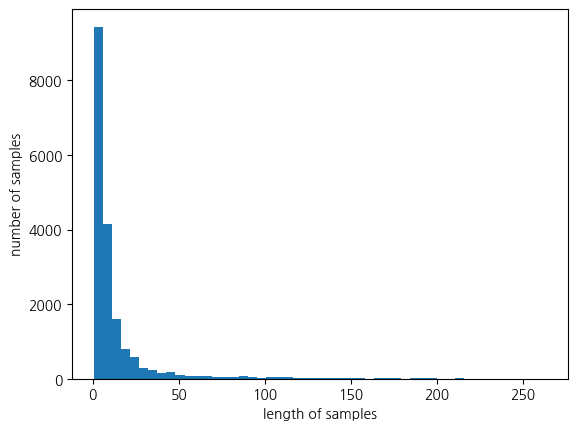

In [125]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [126]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [127]:
# max_len = 50 을 가정후 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인
max_len = 50
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 50 이하인 샘플의 비율: 94.7842605156038


In [128]:
#  모든 샘플의 길이를 50으로

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


In [129]:
# print("X_train의 형태:", X_train.shape)
y_train = np.array(y_train)
print("y_train의 형태:", y_train.shape)

y_train의 형태: (18425,)


In [141]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

embedding_dim = 100
hidden_units = 64  # LSTM 유닛 수 감소

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(Dropout(0.3))  # Dropout 비율 증가
model.add(BatchNormalization())  # Batch Normalization 추가
model.add(LSTM(hidden_units))
model.add(Dropout(0.3))  # Dropout 비율 증가
model.add(BatchNormalization())  # Batch Normalization 추가
model.add(Dense(1, activation='sigmoid'))

mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 학습률 조정
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)  # 기본값보다 낮은 학습률

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])  
history = model.fit(X_train, y_train, epochs=20, callbacks=[mc], batch_size=32, validation_split=0.2)

Epoch 1/20
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.5039 - loss: 0.7822
Epoch 1: val_acc improved from -inf to 0.50041, saving model to best_model.keras
461/461 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - acc: 0.5039 - loss: 0.7821 - val_acc: 0.5004 - val_loss: 0.6945
Epoch 2/20
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.5158 - loss: 0.7420
Epoch 2: val_acc did not improve from 0.50041
461/461 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - acc: 0.5158 - loss: 0.7420 - val_acc: 0.4977 - val_loss: 0.7056
Epoch 3/20
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.5518 - loss: 0.7156
Epoch 3: val_acc did not improve from 0.50041
461/461 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - acc: 0.5517 - loss: 0.7156 - val_acc: 0.4982 - val_loss: 0.7108
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.5692 - loss: 0.6892
Epoch 4: val_acc did not improve from 0.50041
461/461 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - acc: 0.5692 - loss: 0.6892 - val_acc: 0.4923 - val_loss: 0.7792
Epoch 5/20
461/46

KeyboardInterrupt: 

In [136]:
loaded_model = load_model('best_model.keras')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - acc: 0.5645 - loss: 0.7713

 테스트 정확도: 0.5641


In [138]:
# 모델 구축

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  # 추가된 레이어
model.add(Dropout(0.5))  # 드롭아웃 추가
model.add(Dense(1, activation='sigmoid'))  # 이진 분류

In [ ]:
# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
# 모델 학습
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping],verbose=1)  # 20%를 검증 데이터로 사용

In [20]:
# 모델 평가

y_pred = model.predict(X_test)
y_pred_classes = [1 if p > 0.5 else 0 for p in y_pred]

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


1. Precision (정밀도):

- 정의: 모델이 양성으로 예측한 것 중 실제로 양성인 비율.
- 수식:

Precision=TP/TP+FP
Precision=TP+FP/TP​

여기서 TP는 True Positive, FP는 False Positive입니다.

2. Recall (재현율):

- 정의: 실제 양성 중에서 모델이 양성으로 올바르게 예측한 비율.
- 수식:

Recall=TP/TP+FN
Recall=TP+FN/TP​

여기서 FN은 False Negative입니다.

3. F1 Score:

- 정의: 정밀도와 재현율의 조화 평균. 두 지표의 균형을 고려합니다.
- 수식:

F1=2×Precision×Recall/Precision+Recall
F1=2×Precision+Recall/Precision×Recall​

In [21]:
# 성능 평가

# classification_report :  정밀도(precision), 재현율(recall), F1 점수(F1 score) 등의 다양한 지표를 포함
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3294
           1       0.97      0.96      0.97      3196

    accuracy                           0.97      6490
   macro avg       0.97      0.97      0.97      6490
weighted avg       0.97      0.97      0.97      6490



In [22]:
# 주식 커뮤니티 샘플 문장
test_samples = [
    "이 회사의 성장 가능성이 정말 기대돼요! 앞으로 주가가 오를 것 같습니다.",  # 긍정
    "이번 분기 실적이 예상보다 좋았어요. 강력한 매수 추천합니다!",  # 긍정
    "이 주식은 장기 투자로 정말 좋은 선택입니다. 믿고 투자하세요!",  # 긍정
    "이 회사는 실적이 계속 나빠지고 있어요. 이제는 매도해야 할 때인 것 같습니다.",  # 부정
    "주가가 너무 비싸요. 조정이 올 것 같아서 걱정입니다."  # 부정
]

In [23]:
X_test_samples = vectorizer.transform(test_samples)

In [24]:
# 예측
y_pred = model.predict(X_test_samples)
y_pred_classes = [1 if p > 0.5 else 0 for p in y_pred]

# 결과 출력
for sample, pred in zip(test_samples, y_pred_classes):
    sentiment = "긍정" if pred == 1 else "부정"
    print(f"문장: '{sample}' -> 예측: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
문장: '이 회사의 성장 가능성이 정말 기대돼요! 앞으로 주가가 오를 것 같습니다.' -> 예측: 긍정
문장: '이번 분기 실적이 예상보다 좋았어요. 강력한 매수 추천합니다!' -> 예측: 긍정
문장: '이 주식은 장기 투자로 정말 좋은 선택입니다. 믿고 투자하세요!' -> 예측: 부정
문장: '이 회사는 실적이 계속 나빠지고 있어요. 이제는 매도해야 할 때인 것 같습니다.' -> 예측: 부정
문장: '주가가 너무 비싸요. 조정이 올 것 같아서 걱정입니다.' -> 예측: 긍정
